# Introduction 

This notebook trains a model to identify defects on mobile phone screens like cracks, spots, or oil stains. The goal is to automate visual inspection to catch defects early in manufacturing.

U-Net is a type of neural network invented by researchers at the University of Freiburg in Germany in 2015. It has a U-shape with downsampling and upsampling paths to enable precise segmentation of images. Downsampling extracts high-level features while upsampling localizes defects accurately.

The dataset contains images of mobile screens with three types of defects - oil, scratches, and stains. Each image has a corresponding mask that highlights the defect location. 

Manual visual inspection of screens is tedious, slow, prone to errors, and unable to handle high volumes. Automating defect detection promises faster and more consistent results at scale, leading to higher quality and lower costs.

First, the data is split into training and validation sets. Then, a U-Net model is designed and trained on the images and masks. The model learns to segment defects pixel-by-pixel. Finally, the trained model is saved.

In [1]:
# Checking for GPUs
!nvidia-smi --query-gpu=gpu_name --format=csv

name
Tesla P100-PCIE-16GB


## Data Preprocessing

In [2]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Define the directory where the dataset is located
dataset_dir = '../input/mobile-phone-defect-segmentation-dataset'
 
# Define the types of defects to consider
defect_types = ['oil', 'scratch', 'stain']

# Define the directories containing the ground truth masks
ground_truth_dirs = ['ground_truth_1', 'ground_truth_2']

In [4]:
# Initialize empty lists to store the image and mask paths
all_image_paths = []
all_mask_paths = []

# Iterate over each defect type
for defect in defect_types:
    # Get the directory containing the images for the current defect type
    defect_images_dir = os.path.join(dataset_dir, defect)
    # Get all the image file names in the current directory
    image_files = sorted(os.listdir(defect_images_dir))
    # Iterate over each image file
    for image_file in image_files:
        # Get the full path to the image
        image_path = os.path.join(defect_images_dir, image_file)

        # Iterate over each ground truth directory
        for ground_truth in ground_truth_dirs:
            # Get the directory containing the masks for the current ground truth directory
            mask_dir = os.path.join(dataset_dir, ground_truth)
            # Get the mask file name corresponding to the current image
            mask_file_name = image_file.replace('.jpg', '.png')
            # Get the full path to the mask
            mask_path = os.path.join(mask_dir, mask_file_name)

            # Check if the mask file exists
            if os.path.exists(mask_path):
                # Add the image and mask paths to the respective lists
                all_image_paths.append(image_path)
                all_mask_paths.append(mask_path)
                # Break out of the inner loop since we have found a valid mask
                break

# Print the total number of images and masks found
print(f"Total images with masks found: {len(all_image_paths)}")
print(f"Total mask paths collected: {len(all_mask_paths)}")

Total images with masks found: 1200
Total mask paths collected: 1200


In [5]:
# Set the maximum column width
pd.options.display.max_colwidth = 100

# Create a pandas DataFrame with 'image' and 'mask' columns
data = pd.DataFrame({'image': all_image_paths,
                     'mask': all_mask_paths})

# Display the first few rows
data.head()

,image,mask
0,../input/mobile-phone-defect-segmentation-dataset/oil/Oil_0001.jpg,../input/mobile-phone-defect-segmentation-dataset/ground_truth_2/Oil_0001.png
1,../input/mobile-phone-defect-segmentation-dataset/oil/Oil_0002.jpg,../input/mobile-phone-defect-segmentation-dataset/ground_truth_2/Oil_0002.png
2,../input/mobile-phone-defect-segmentation-dataset/oil/Oil_0003.jpg,../input/mobile-phone-defect-segmentation-dataset/ground_truth_2/Oil_0003.png
3,../input/mobile-phone-defect-segmentation-dataset/oil/Oil_0004.jpg,../input/mobile-phone-defect-segmentation-dataset/ground_truth_2/Oil_0004.png
4,../input/mobile-phone-defect-segmentation-dataset/oil/Oil_0005.jpg,../input/mobile-phone-defect-segmentation-dataset/ground_truth_2/Oil_0005.png


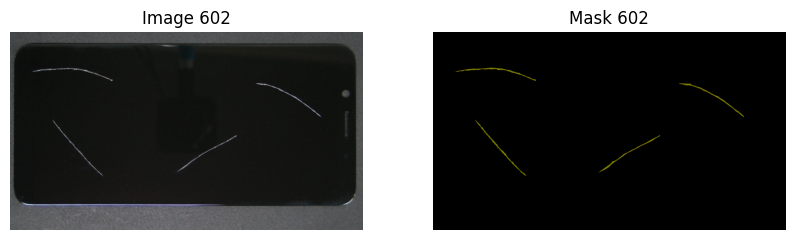

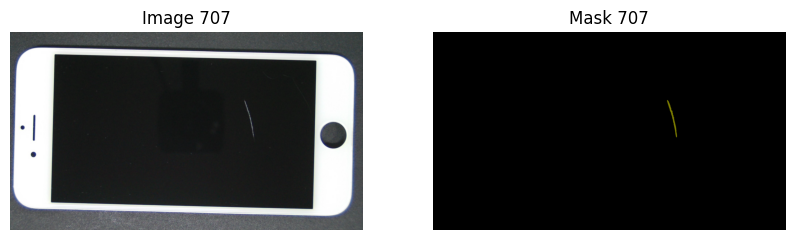

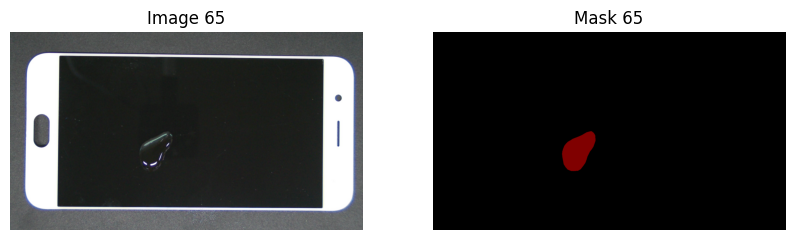

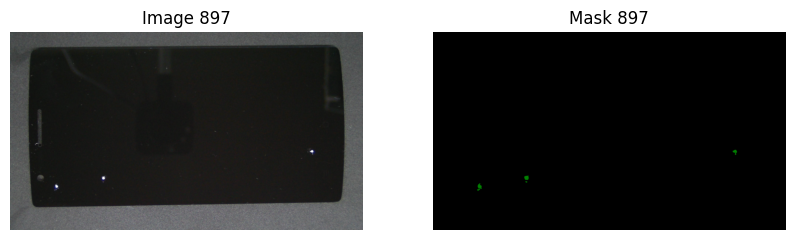

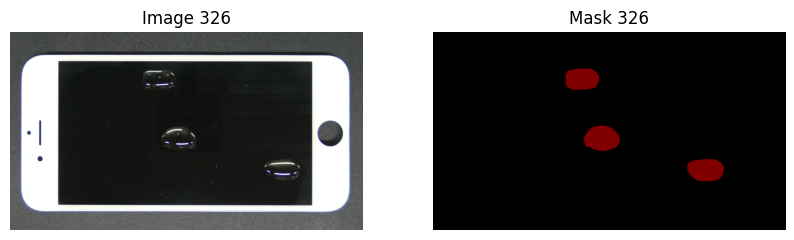

In [6]:
# Diplay five random images and their masks
for i in random.sample(range(len(data)), 5):  # Loop through the 5 randomly selected indices
    image_path = data.at[i, "image"]
    mask_path = data.at[i, "mask"]
    
    # Open the images with PIL
    image = Image.open(image_path)
    mask = Image.open(mask_path)
    
    # Set up the matplotlib subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display the image
    axes[0].imshow(image)
    axes[0].set_title(f'Image {i}')
    axes[0].axis('off')  # Hide the axis
    
    # Display the mask
    axes[1].imshow(mask)
    axes[1].set_title(f'Mask {i}')
    axes[1].axis('off')

    # Show the plots
    plt.show()

## Data Splitting

In [7]:
# Split the data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

## Data Generators

In [8]:
batch_size = 32

In [9]:
# Create image data generator for training masks, and images
train_image_datagen = ImageDataGenerator(rescale=1./255)
train_mask_datagen = ImageDataGenerator(rescale=1./255)

# Generate training image data
train_image_generator = train_image_datagen.flow_from_dataframe(dataframe=train_data,
                                                    x_col='image',
                                                    class_mode=None,
                                                    color_mode='rgb',
                                                    target_size=(256, 256),
                                                    batch_size=batch_size,
                                                    seed=1)

# Generate training mask data
train_mask_generator = train_mask_datagen.flow_from_dataframe(dataframe=train_data,
                                                  x_col='mask',
                                                  class_mode=None,
                                                  color_mode='rgb',
                                                  target_size=(256, 256),
                                                  batch_size=batch_size,
                                                  seed=1)

# Combine image and mask generators into a single generator
train_generator = zip(train_image_generator, train_mask_generator)

Found 960 validated image filenames.
Found 960 validated image filenames.


In [10]:
# Create image data generator for test masks, and images
test_image_datagen = ImageDataGenerator(rescale=1./255)
test_mask_datagen = ImageDataGenerator(rescale=1./255)


# Generate test image data
test_image_generator = test_image_datagen.flow_from_dataframe(dataframe=test_data,
                                                    x_col='image',
                                                    class_mode=None,
                                                    color_mode='rgb',
                                                    target_size=(256, 256),
                                                    batch_size=batch_size,
                                                    seed=1)

# Generate test mask data
test_mask_generator = test_mask_datagen.flow_from_dataframe(dataframe=test_data,
                                                  x_col='mask',
                                                  class_mode=None,
                                                  color_mode='rgb',
                                                  target_size=(256, 256),
                                                  batch_size=batch_size,
                                                  seed=1)

# Combine image and mask generators into a single generator
test_generator = zip(test_image_generator, test_mask_generator)

Found 240 validated image filenames.
Found 240 validated image filenames.


## Model Building

In [11]:
def unet_model(input_size=(256, 256, 3), num_classes=1):
    # Define the input layer
    inputs = Input(input_size)
    
    # Down-sampling through the model (Encoder)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Middle of the U-Net (bottleneck)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Up-sampling through the model (Decoder)
    up6 = concatenate([Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    # Final convolution layer with sigmoid activation for binary classification
    conv10 = Conv2D(num_classes, 1, activation='sigmoid')(conv9)
    
    # Create the model
    model = Model(inputs=[inputs], outputs=[conv10])
    
    return model

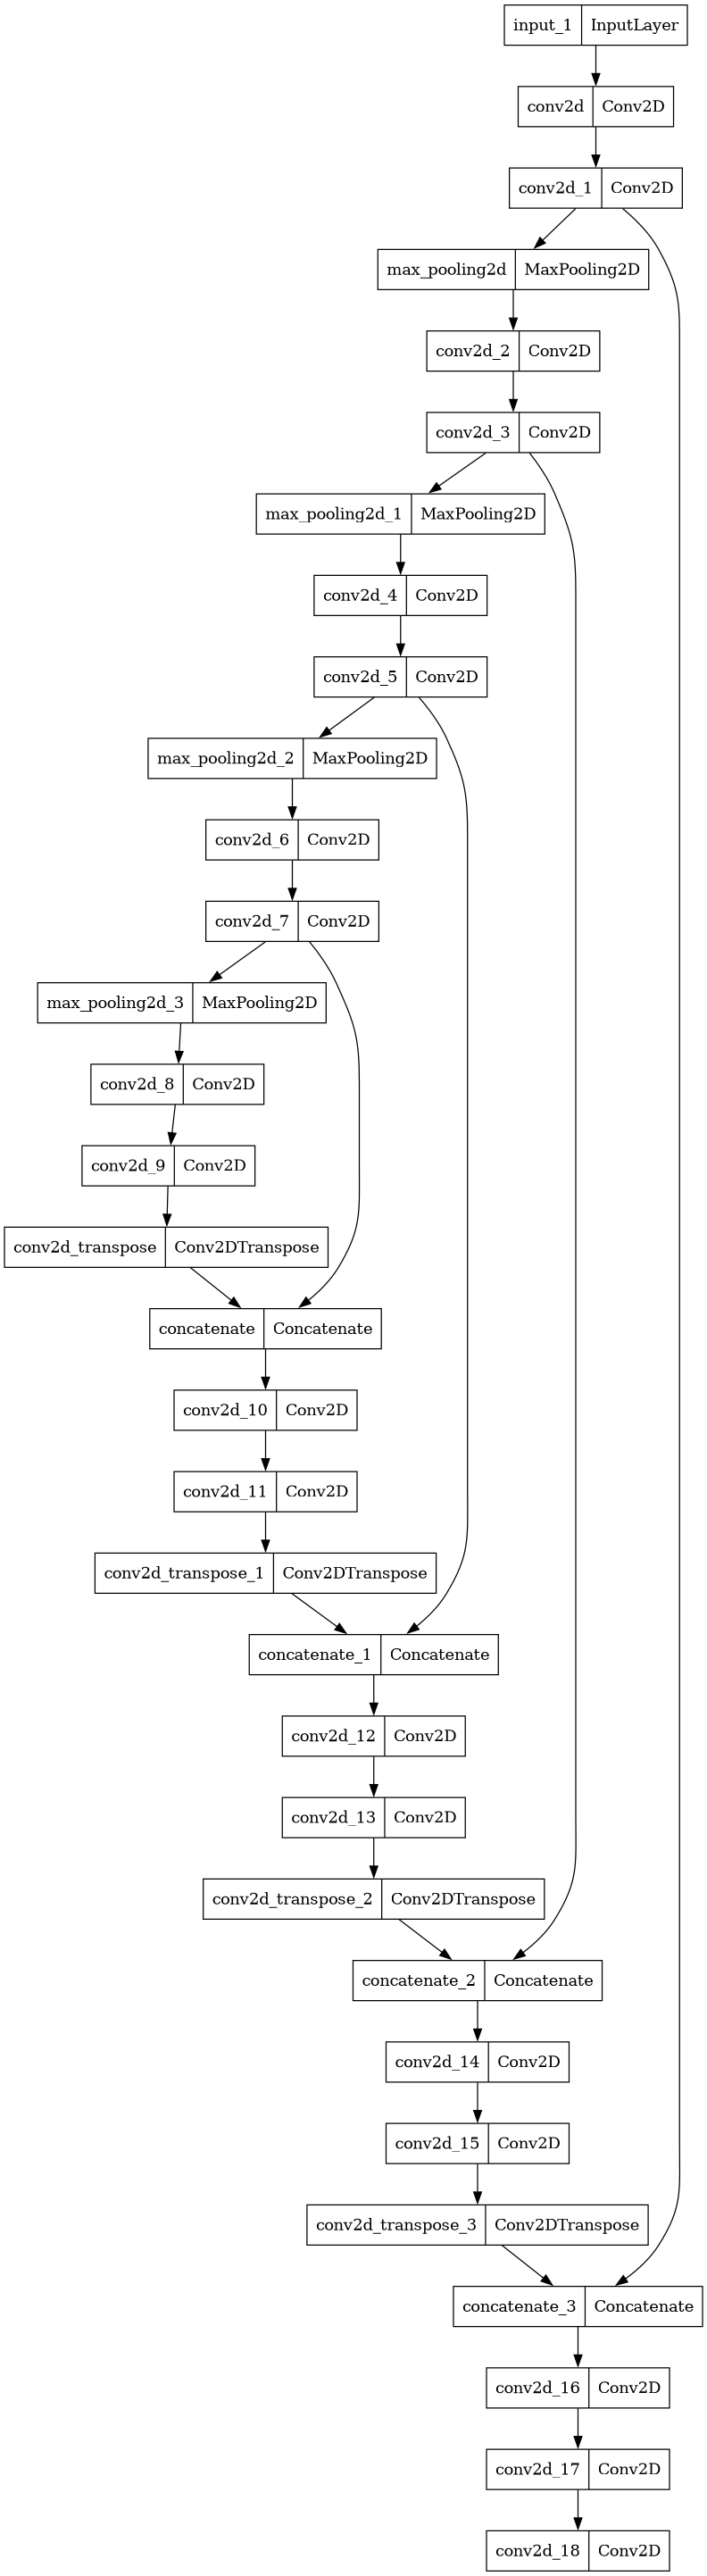

In [12]:
# Instantiate the UNet model
model = unet_model(input_size=(256, 256, 3))

# Plot the model
plot_model(model, dpi=90)

## Model Training

In [13]:
# Create an Adam optimizer
adam_optimizer = Adam(learning_rate=1e-3)

# Compile the model with the custom optimizer
model.compile(optimizer=adam_optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
# Train the model
history = model.fit(train_generator, epochs=2,
                    steps_per_epoch=len(train_image_generator),
                    validation_data=test_generator,
                    validation_steps=len(test_image_generator))

Epoch 1/2
30/30 [==============================] - 127s 3s/step - loss: 0.0692 - accuracy: 0.9964 - val_loss: 0.0241 - val_accuracy: 0.9920
Epoch 2/2
30/30 [==============================] - 83s 3s/step - loss: 0.1165 - accuracy: 0.9761 - val_loss: 0.1263 - val_accuracy: 0.9966


## Model Saving

In [15]:
# Save the model
model.save('unet_mobile_phone_defect_segmentation.keras')

# Conclusion

We implemented an end-to-end deep learning pipeline for segmenting defects on mobile phone screens. The U-Net model was trained on images of 3 defect types - oil, scratches and stains. After 2 epochs, the model achieved 99% training accuracy and 99.6% validation accuracy, indicating it learned to accurately segment defects.

## Future Work 

While the results are promising, the model can be improved further:

- Augment the dataset with artificially generated defects to make the model more robust.

- Experiment with newer architectural variants of U-Net.

- Train on larger resolution images for precise defect localization. 

- Expand the defect categories by collecting more training data.

- Ensemble the model with other segmentation models like DeepLabv3+ for increased performance.

This notebook shows the potential of using deep learning for automated visual inspection. With more data and model tuning, the defect segmentation model can be productionized to automate quality control and provide business value.